<a href="https://colab.research.google.com/github/yardenfren1996/B-LoRA/blob/main/B_LoRA_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q diffusers==0.25.0 accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.6 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/yardenfren1996/B-LoRA.git
%cd B-LoRA

fatal: destination path 'B-LoRA' already exists and is not an empty directory.
/content/B-LoRA


In [3]:
import torch
from diffusers import StableDiffusionXLPipeline, AutoencoderKL
from blora_utils import BLOCKS, filter_lora, scale_lora
import matplotlib.pyplot as plt

def plot_images(images, titles=None, figsize=(15, 5)):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)

    for i, img in enumerate(images):
        axes[i].imshow(img)
        if titles:
            axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.show()

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipeline = StableDiffusionXLPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        vae=vae,
        torch_dtype=torch.float16,
    ).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## Inference
In the following code, we will show few examples of how to utilize B-LoRA.
You can use our B-LoRAs from the HF 🤗 library `lora-library` in the following template: `lora-library/B-LoRA-<Name>`.
Or you can train your own B-LoRAs

| Image | Name  | Instance Prompt |
|-----------|-----------|-----------|
| <img src="https://b-lora.github.io/B-LoRA/static/figures/content_images/bull.jpg" alt="bull" width="200" height="200"> | <font size="5">bull</font> | <font size="5">A [v3]</font> |
| <img src="https://b-lora.github.io/B-LoRA/static/figures/content_images/teddybear.jpg" alt="teddybear" width="200" height="200"> | <font size="5">teddybear</font> | <font size="5">A [v18]</font> |
| <img src="https://b-lora.github.io/B-LoRA/static/figures/content_images/wolf_plushie.jpg" alt="wolf_plushie" width="200" height="200"> | <font size="5">wolf_plushie</font> | <font size="5">A [v38]</font> |
| <img src="https://b-lora.github.io/B-LoRA/static/figures/style_images/pen_sketch.jpeg" alt="pen_sketch" width="200" height="200"> | <font size="5">pen_sketch</font> | <font size="5">A [v30] |
| <img src="https://b-lora.github.io/B-LoRA/static/figures/style_images/cartoon_line.png" alt="cartoon_line" width="200" height="200"> | <font size="5">cartoon_line</font> | <font size="5">A [v5] |
| <img src="https://b-lora.github.io/B-LoRA/static/figures/content_images/dog2.jpg" alt="dog2" width="200" height="200"> | <font size="5">dog2</font> | <font size="5">A [v] dog</font> |


Note that the last example of `dog2` is different, as it was trained on multiple images for recontextualization, as we will demonstrate next.

![apps method](https://b-lora.github.io/B-LoRA/static/figures/apps_method1.png)

In [5]:
def load_b_lora_to_unet(pipe, content_lora_model_id: str = '', style_lora_model_id: str = '', content_alpha: float = 1.,
                            style_alpha: float = 1.) -> None:
        try:
            # Get Content B-LoRA SD
            if content_lora_model_id:
                content_B_LoRA_sd, _ = pipe.lora_state_dict(content_lora_model_id)
                content_B_LoRA = filter_lora(content_B_LoRA_sd, BLOCKS['content'])
                content_B_LoRA = scale_lora(content_B_LoRA, content_alpha)
            else:
                content_B_LoRA = {}

            # Get Style B-LoRA SD
            if style_lora_model_id:
                style_B_LoRA_sd, _ = pipe.lora_state_dict(style_lora_model_id)
                style_B_LoRA = filter_lora(style_B_LoRA_sd, BLOCKS['style'])
                style_B_LoRA = scale_lora(style_B_LoRA, style_alpha)
            else:
                style_B_LoRA = {}

            # Merge B-LoRAs SD
            res_lora = {**content_B_LoRA, **style_B_LoRA}

            # Load
            pipe.load_lora_into_unet(res_lora, None, pipe.unet)
        except Exception as e:
            raise type(e)(f'failed to load_b_lora_to_unet, due to: {e}')

## Image Stylization Based On Image Style Reference

In [6]:
content_B_LoRA_path = 'lora-library/B-LoRA-teddybear'
style_B_LoRA_path = 'lora-library/B-LoRA-pen_sketch'
content_alpha,style_alpha = 1,1.1

In [7]:
load_b_lora_to_unet(pipeline, content_B_LoRA_path, style_B_LoRA_path, content_alpha, style_alpha)

/usr/local/lib/python3.10/dist-packages/diffusers/loaders/lora.py:407: FutureWarning: `unet.unet keys` is deprecated and will be removed in version 0.27. Keys starting with 'unet.unet' are deprecated.
  deprecate("unet.unet keys", "0.27", deprecation_message)


  0%|          | 0/50 [00:00<?, ?it/s]

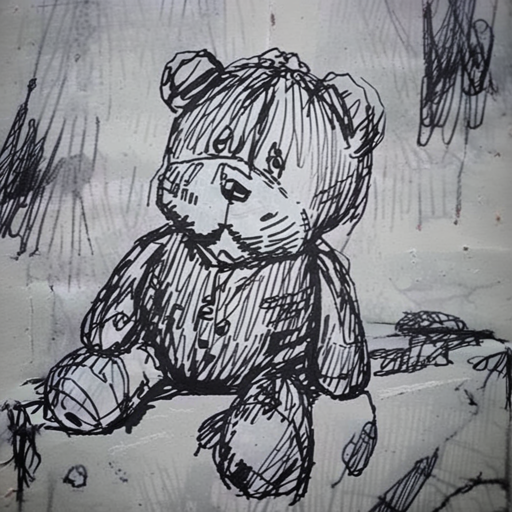

In [8]:
prompt = 'A [v18] in [v30] style'
image = pipeline(prompt,generator=torch.Generator(device="cuda").manual_seed(48), num_images_per_prompt=1).images[0].resize((512,512))
image

### Unload B-LoRA

In [9]:
pipeline.unload_lora_weights()

You are using `unload_lora_weights` to disable and unload lora weights. If you want to iteratively enable and disable adapter weights,you can use `pipe.enable_lora()` or `pipe.disable_lora()`. After installing the latest version of PEFT.
/usr/local/lib/python3.10/dist-packages/diffusers/loaders/lora.py:777: FutureWarning: `_remove_text_encoder_monkey_patch_classmethod` is deprecated and will be removed in version 0.27. You are using an old version of LoRA backend. This will be deprecated in the next releases in favor of PEFT make sure to install the latest PEFT and transformers packages in the future.
  deprecate("_remove_text_encoder_monkey_patch_classmethod", "0.27", LORA_DEPRECATION_MESSAGE)


## Image Stylization Based On Text Reference

In [10]:
content_B_LoRA_path = 'lora-library/B-LoRA-bull'
style_B_LoRA_path = ''
content_alpha,style_alpha = 1,1

In [11]:
load_b_lora_to_unet(pipeline, content_B_LoRA_path, style_B_LoRA_path, content_alpha, style_alpha)

pytorch_lora_weights.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

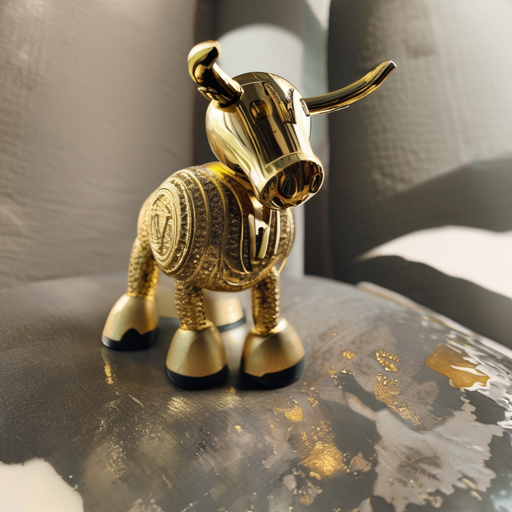

In [12]:
prompt = 'A [v3] made of gold'
image = pipeline(prompt,generator=torch.Generator(device="cuda").manual_seed(48), num_images_per_prompt=1).images[0].resize((512,512))
image

### Unload B-LoRA

In [13]:
pipeline.unload_lora_weights()

You are using `unload_lora_weights` to disable and unload lora weights. If you want to iteratively enable and disable adapter weights,you can use `pipe.enable_lora()` or `pipe.disable_lora()`. After installing the latest version of PEFT.


## Consistent Style Generation

In [14]:
content_B_LoRA_path = ''
style_B_LoRA_path = 'lora-library/B-LoRA-wolf_plushie'
content_alpha,style_alpha = 1,1.1

In [15]:
load_b_lora_to_unet(pipeline, content_B_LoRA_path, style_B_LoRA_path, content_alpha, style_alpha)

pytorch_lora_weights.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

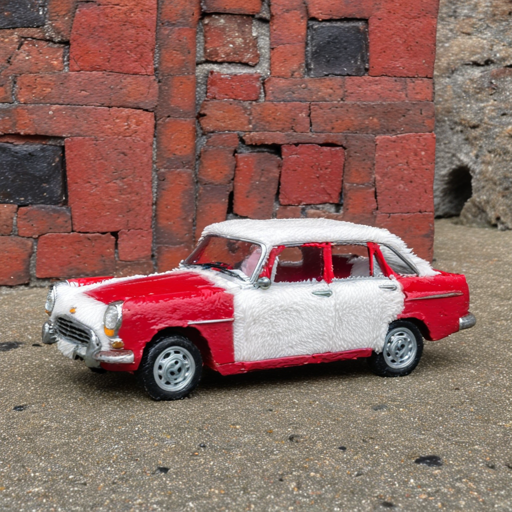

In [16]:
prompt = 'A car in [v38] style'
image = pipeline(prompt, generator=torch.Generator(device="cuda").manual_seed(48), num_images_per_prompt=1).images[0].resize((512,512))
image

### Unload B-LoRA

In [17]:
pipeline.unload_lora_weights()

You are using `unload_lora_weights` to disable and unload lora weights. If you want to iteratively enable and disable adapter weights,you can use `pipe.enable_lora()` or `pipe.disable_lora()`. After installing the latest version of PEFT.


## B-LoRA for Personalization

In [18]:
content_B_LoRA_path = 'lora-library/B-LoRA-multi-dog2'
style_B_LoRA_path = 'lora-library/B-LoRA-wolf_plushie'
content_alpha,style_alpha = 1,1.1

In [19]:
load_b_lora_to_unet(pipeline, content_B_LoRA_path, style_B_LoRA_path, content_alpha, style_alpha)

pytorch_lora_weights.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

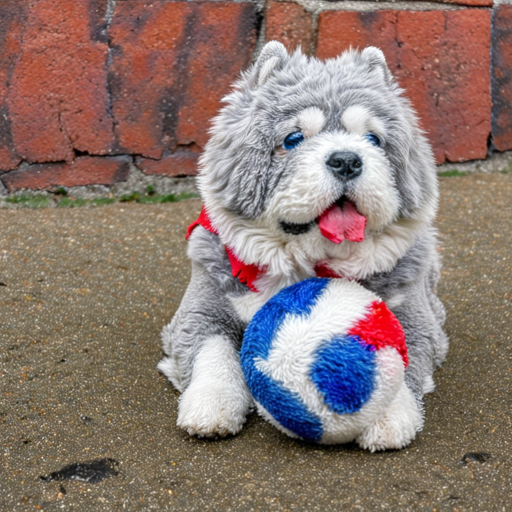

In [20]:
prompt = 'A [v] dog playing with a ball in [v38] style'
image = pipeline(prompt,generator=torch.Generator(device="cuda").manual_seed(12), num_images_per_prompt=1).images[0].resize((512,512))
image

### Unload B-LoRA

In [21]:
pipeline.unload_lora_weights()

You are using `unload_lora_weights` to disable and unload lora weights. If you want to iteratively enable and disable adapter weights,you can use `pipe.enable_lora()` or `pipe.disable_lora()`. After installing the latest version of PEFT.
